1. Setup and Imports

In [1]:
# %% [markdown]
# # Agricultural Crop Yield Prediction
# 
# ## Project Overview
# This project aims to predict crop yields based on environmental factors to help farmers with better planning and decision-making.

# %% [markdown]
# ## 1. Introduction
# 
# **Agricultural Context:**
# Agriculture faces challenges from climate volatility and resource scarcity. Accurate yield prediction enables optimal resource allocation, efficient supply chain management, and better financial planning.
# 
# **Objectives:**
# - Integrate and analyze historical weather, soil, and yield data
# - Identify key environmental factors influencing crop yield
# - Develop robust regression models for accurate yield prediction
# - Provide actionable insights for farmers and planners

# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


2. Data Creation

In [2]:
# %%
# Create sample agricultural dataset
def create_agricultural_data(n_samples=1000):
    """Create a synthetic agricultural dataset for crop yield prediction"""
    
    np.random.seed(42)
    
    data = {
        'temperature': np.random.normal(25, 5, n_samples),
        'rainfall': np.random.gamma(2, 50, n_samples),
        'humidity': np.random.normal(65, 15, n_samples),
        'soil_ph': np.random.normal(6.5, 0.8, n_samples),
        'soil_nitrogen': np.random.normal(50, 15, n_samples),
        'soil_phosphorus': np.random.normal(40, 12, n_samples),
        'soil_potassium': np.random.normal(45, 10, n_samples),
        'sunlight_hours': np.random.normal(8, 2, n_samples),
    }
    
    df = pd.DataFrame(data)
    
    # Create realistic crop types
    crops = ['Wheat', 'Rice', 'Corn', 'Soybean', 'Barley']
    df['crop_type'] = np.random.choice(crops, n_samples)
    
    # Generate realistic yield based on features with some noise
    base_yield = (
        df['temperature'] * 0.3 +
        df['rainfall'] * 0.2 +
        df['humidity'] * 0.1 +
        df['soil_nitrogen'] * 0.4 +
        df['soil_phosphorus'] * 0.3 +
        df['soil_potassium'] * 0.3 +
        df['sunlight_hours'] * 0.5
    )
    
    # Adjust base yield by crop type
    crop_multipliers = {'Wheat': 1.2, 'Rice': 1.5, 'Corn': 1.8, 'Soybean': 1.1, 'Barley': 1.0}
    for crop, multiplier in crop_multipliers.items():
        mask = df['crop_type'] == crop
        base_yield[mask] = base_yield[mask] * multiplier
    
    # Add some noise and scale to realistic yield values
    noise = np.random.normal(0, 50, n_samples)
    df['yield'] = base_yield + noise
    df['yield'] = df['yield'].clip(lower=100)  # Ensure minimum yield
    
    return df

# Generate the dataset
crop_data = create_agricultural_data(1000)
print("Dataset created successfully!")
print(f"Dataset shape: {crop_data.shape}")
print("\nFirst 5 rows:")
print(crop_data.head())

Dataset created successfully!
Dataset shape: (1000, 10)

First 5 rows:
   temperature    rainfall   humidity   soil_ph  soil_nitrogen  \
0    27.483571  210.228597  88.443332  7.328870      58.817838   
1    24.308678  158.401247  60.890104  5.361620      59.296082   
2    28.238443   87.242024  61.349240  5.723901      21.330247   
3    32.615149   48.160808  60.502427  6.181954      51.394689   
4    23.829233  155.503029  93.562049  7.490123      42.972558   

   soil_phosphorus  soil_potassium  sunlight_hours crop_type       yield  
0        26.761787       33.480025        9.283894   Soybean  154.804306  
1        49.846642       46.090830        7.459465    Barley  100.000000  
2        42.211709       48.859701        8.435436      Corn  168.894889  
3        34.959667       33.233551        6.350699    Barley  100.000000  
4        17.143904       54.280906        9.406984      Rice  188.661321  


3. Exploratory Data Analysis


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      1000 non-null   float64
 1   rainfall         1000 non-null   float64
 2   humidity         1000 non-null   float64
 3   soil_ph          1000 non-null   float64
 4   soil_nitrogen    1000 non-null   float64
 5   soil_phosphorus  1000 non-null   float64
 6   soil_potassium   1000 non-null   float64
 7   sunlight_hours   1000 non-null   float64
 8   crop_type        1000 non-null   object 
 9   yield            1000 non-null   float64
dtypes: float64(9), object(1)
memory usage: 78.3+ KB
None

Dataset Description:
       temperature     rainfall     humidity      soil_ph  soil_nitrogen  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean     25.096660   102.436596    64.702025     6.452686      49.702300   
std       4.896080  

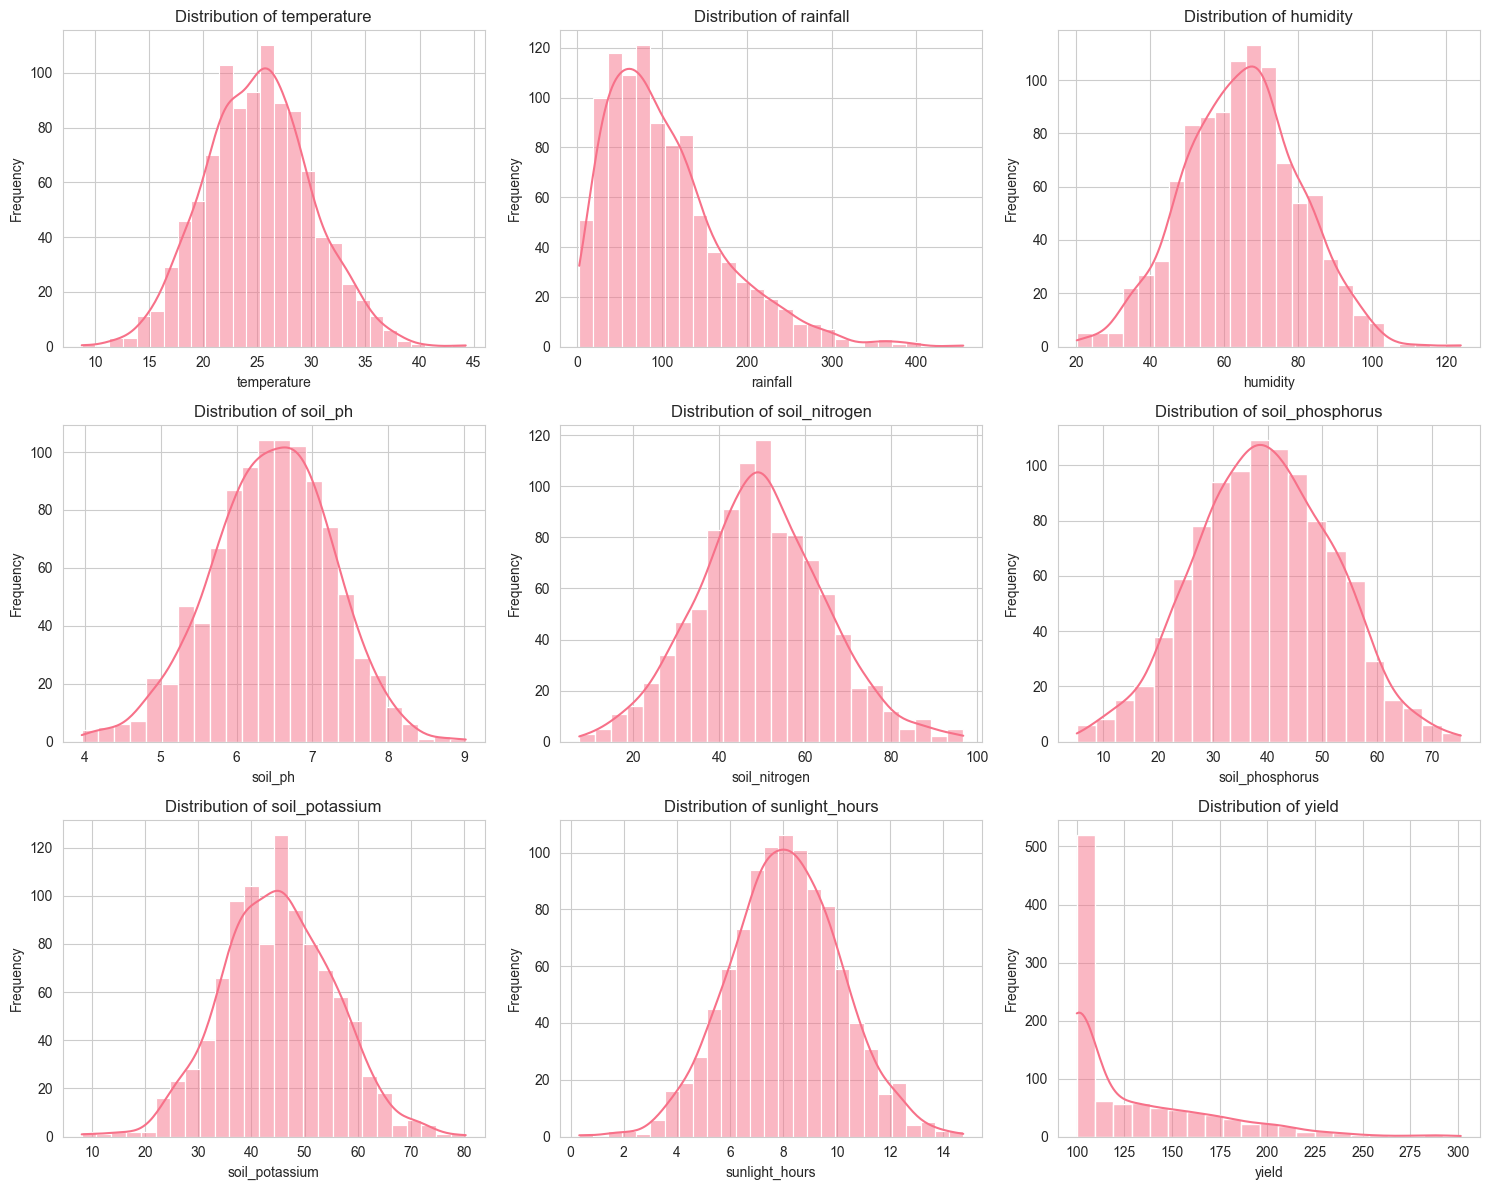

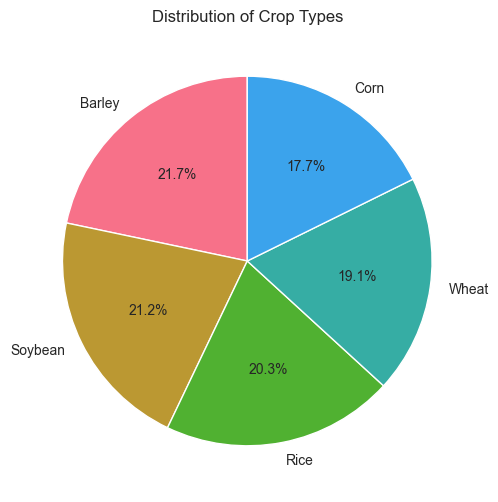

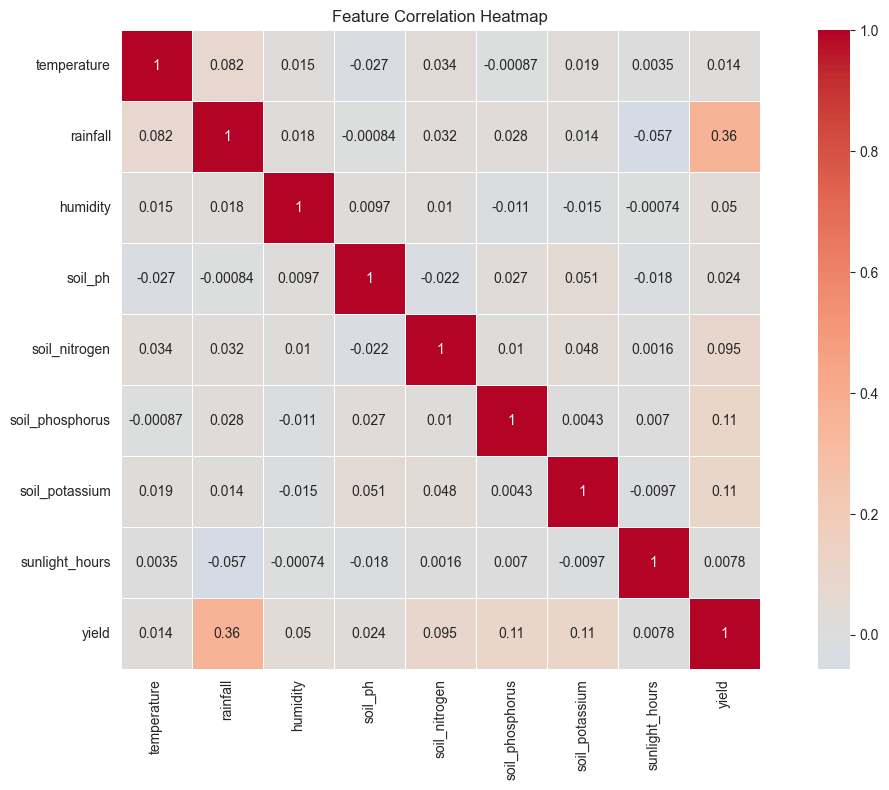

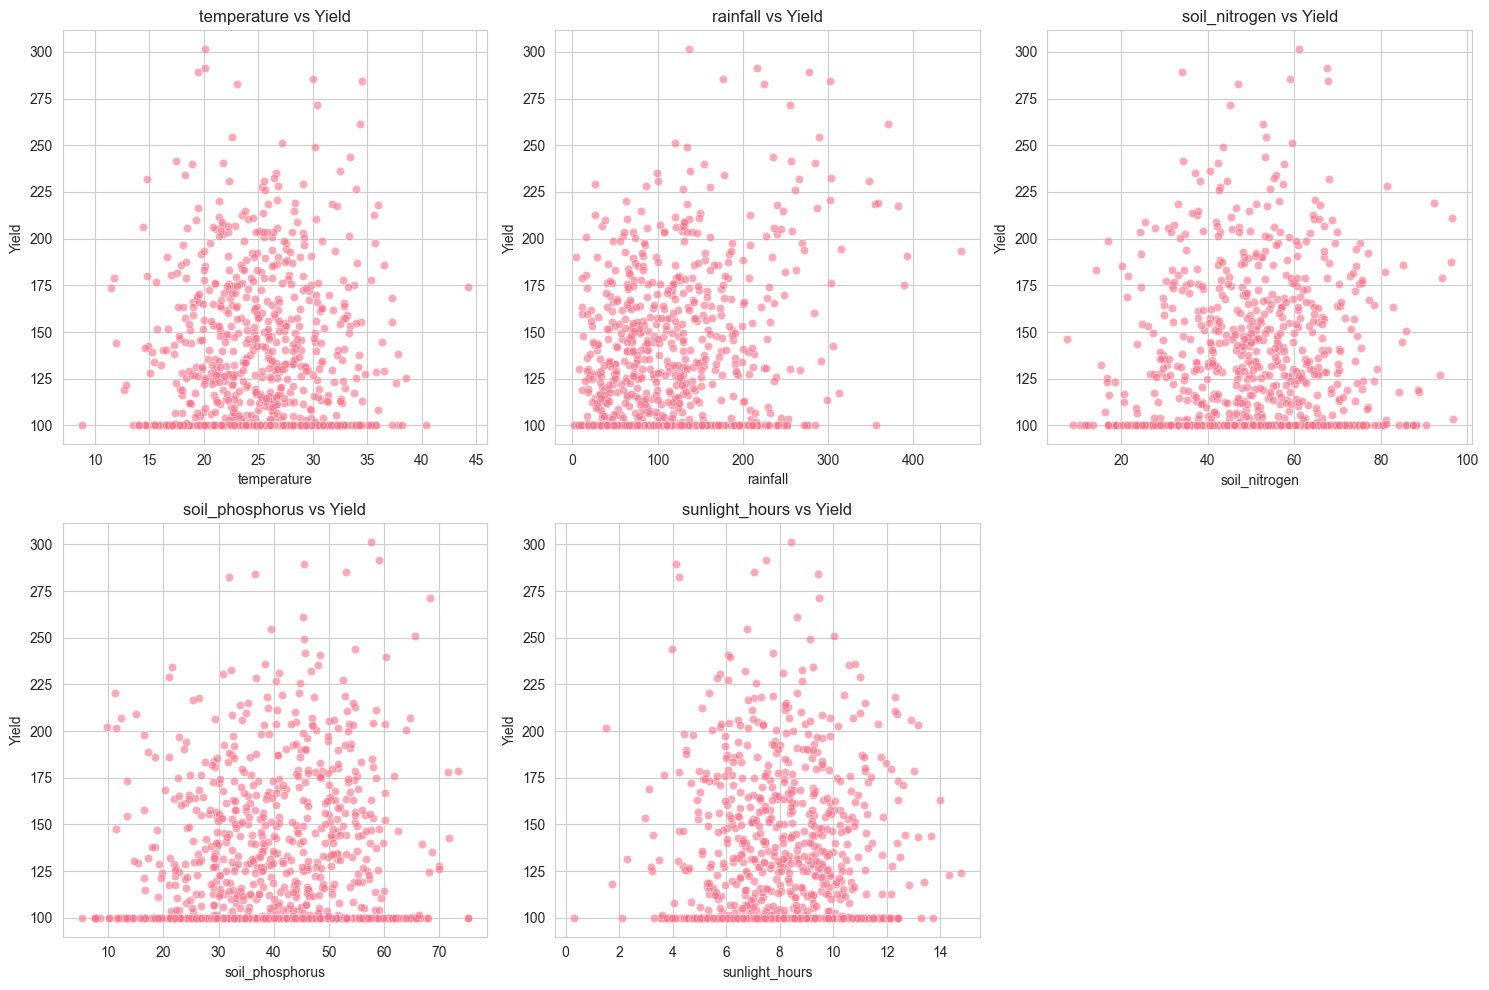

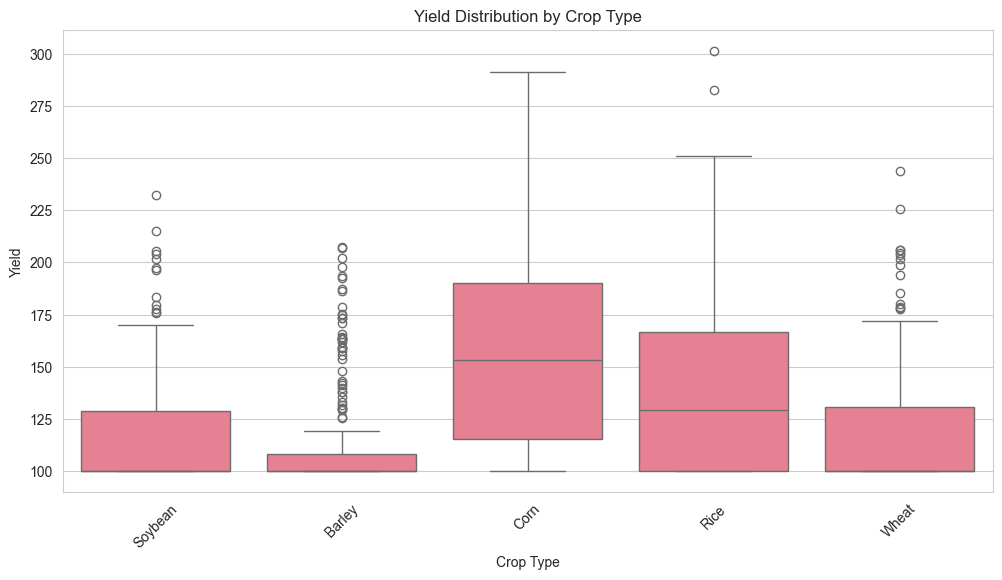

In [3]:
# %%
# Basic data exploration
print("Dataset Info:")
print(crop_data.info())
print("\nDataset Description:")
print(crop_data.describe())
print("\nMissing values:")
print(crop_data.isnull().sum())

# %%
# Visualize the distribution of numerical features
plt.figure(figsize=(15, 12))
numerical_features = ['temperature', 'rainfall', 'humidity', 'soil_ph', 
                     'soil_nitrogen', 'soil_phosphorus', 'soil_potassium', 
                     'sunlight_hours', 'yield']

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(crop_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# %%
# Crop type distribution
plt.figure(figsize=(10, 6))
crop_counts = crop_data['crop_type'].value_counts()
plt.pie(crop_counts.values, labels=crop_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Crop Types')
plt.show()

# %%
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = crop_data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# %%
# Feature relationships with yield
plt.figure(figsize=(15, 10))
features_to_plot = ['temperature', 'rainfall', 'soil_nitrogen', 'soil_phosphorus', 'sunlight_hours']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=crop_data, x=feature, y='yield', alpha=0.6)
    plt.title(f'{feature} vs Yield')
    plt.xlabel(feature)
    plt.ylabel('Yield')

plt.tight_layout()
plt.show()

# %%
# Yield by crop type
plt.figure(figsize=(12, 6))
sns.boxplot(data=crop_data, x='crop_type', y='yield')
plt.title('Yield Distribution by Crop Type')
plt.xlabel('Crop Type')
plt.ylabel('Yield')
plt.xticks(rotation=45)
plt.show()

4. Data Preprocessing for Modeling

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      1000 non-null   float64
 1   rainfall         1000 non-null   float64
 2   humidity         1000 non-null   float64
 3   soil_ph          1000 non-null   float64
 4   soil_nitrogen    1000 non-null   float64
 5   soil_phosphorus  1000 non-null   float64
 6   soil_potassium   1000 non-null   float64
 7   sunlight_hours   1000 non-null   float64
 8   crop_type        1000 non-null   object 
 9   yield            1000 non-null   float64
dtypes: float64(9), object(1)
memory usage: 78.3+ KB
None

Dataset Description:
       temperature     rainfall     humidity      soil_ph  soil_nitrogen  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean     25.096660   102.436596    64.702025     6.452686      49.702300   
std       4.896080  

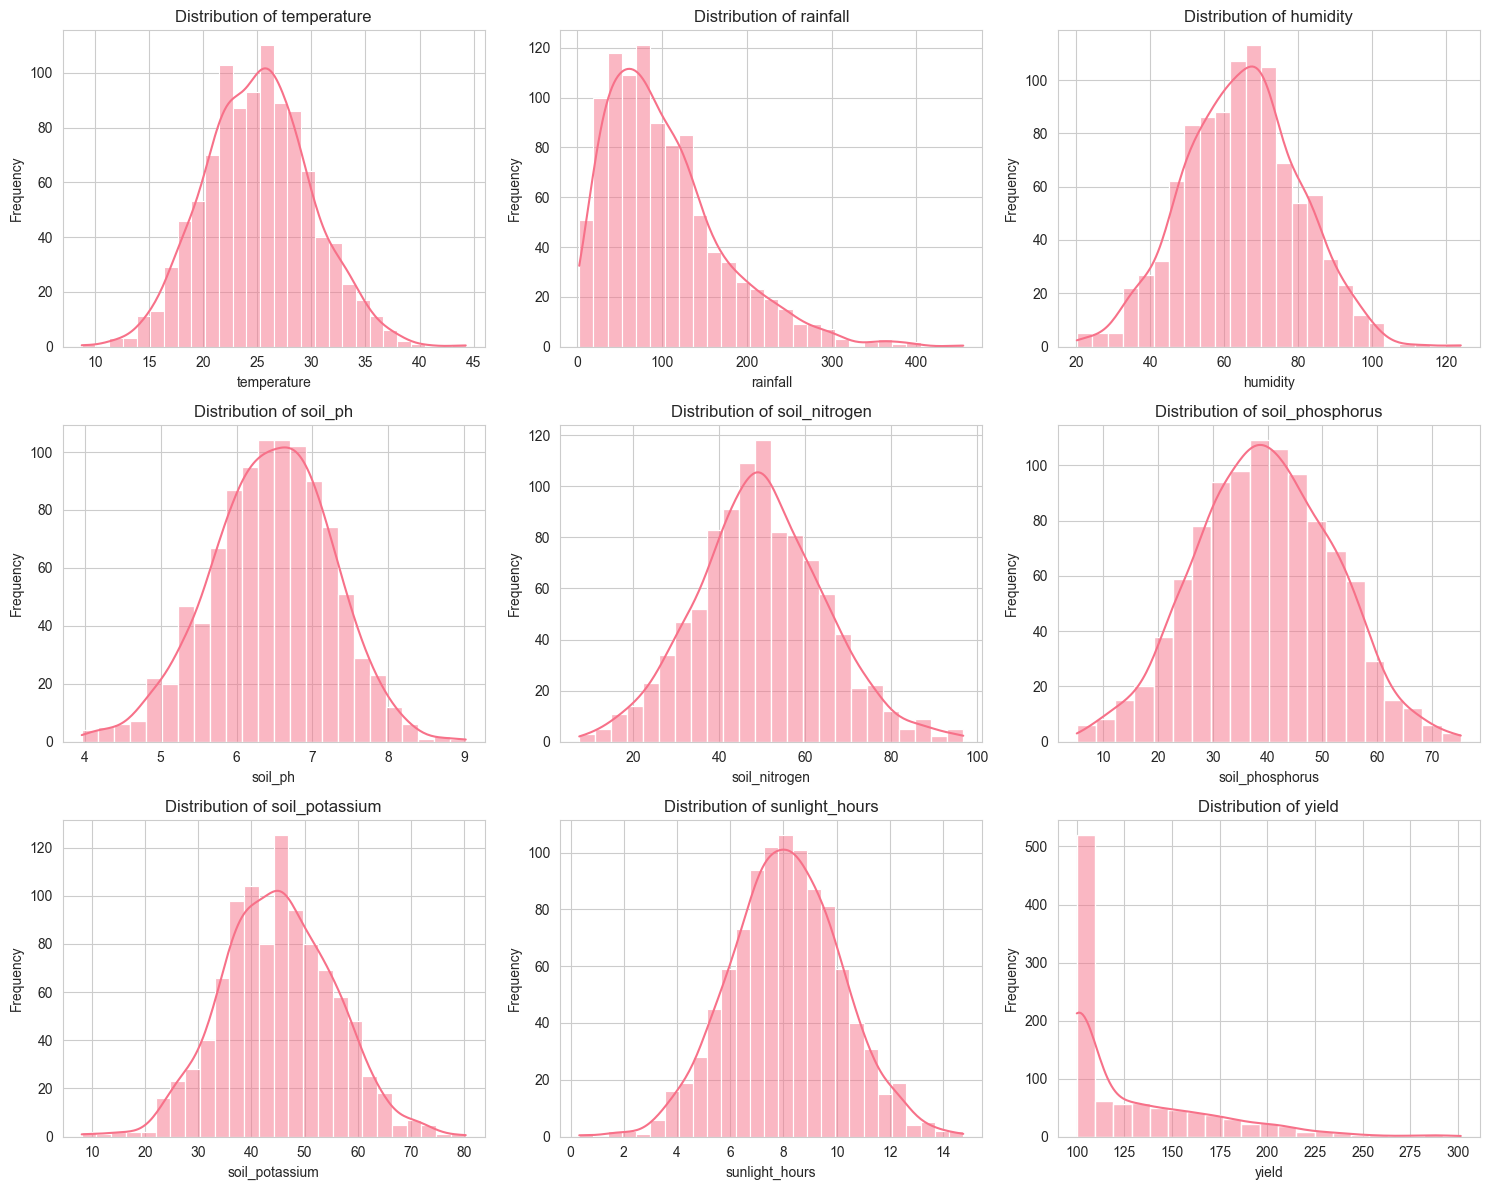

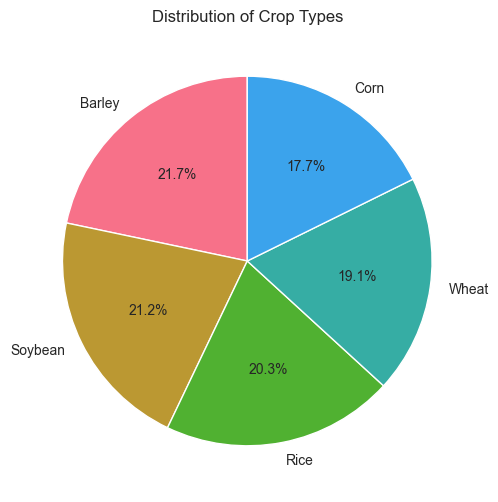

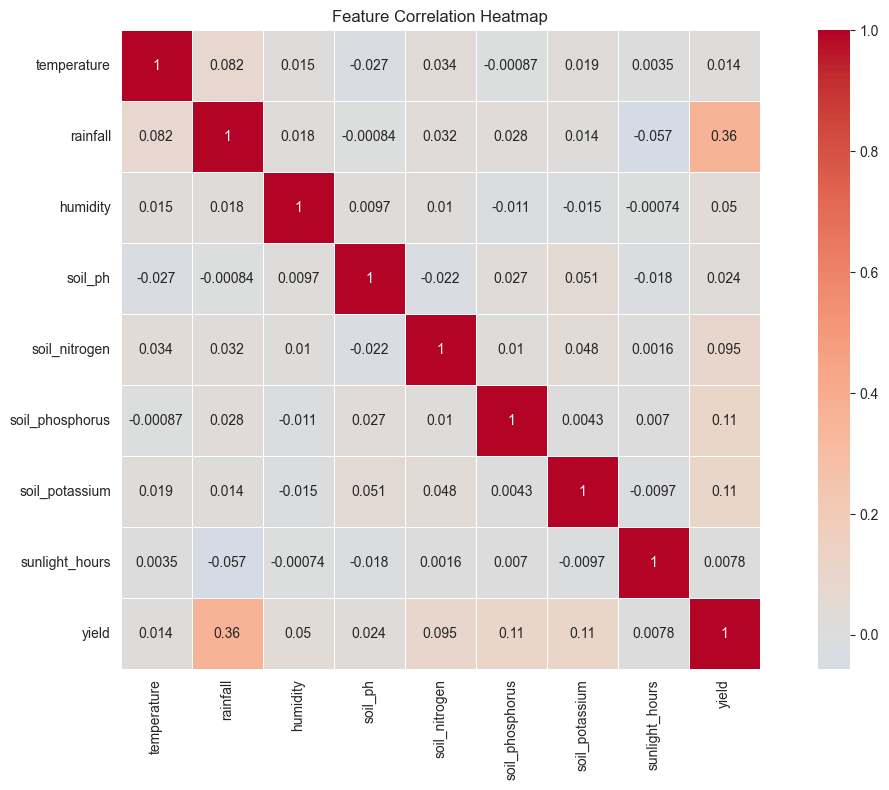

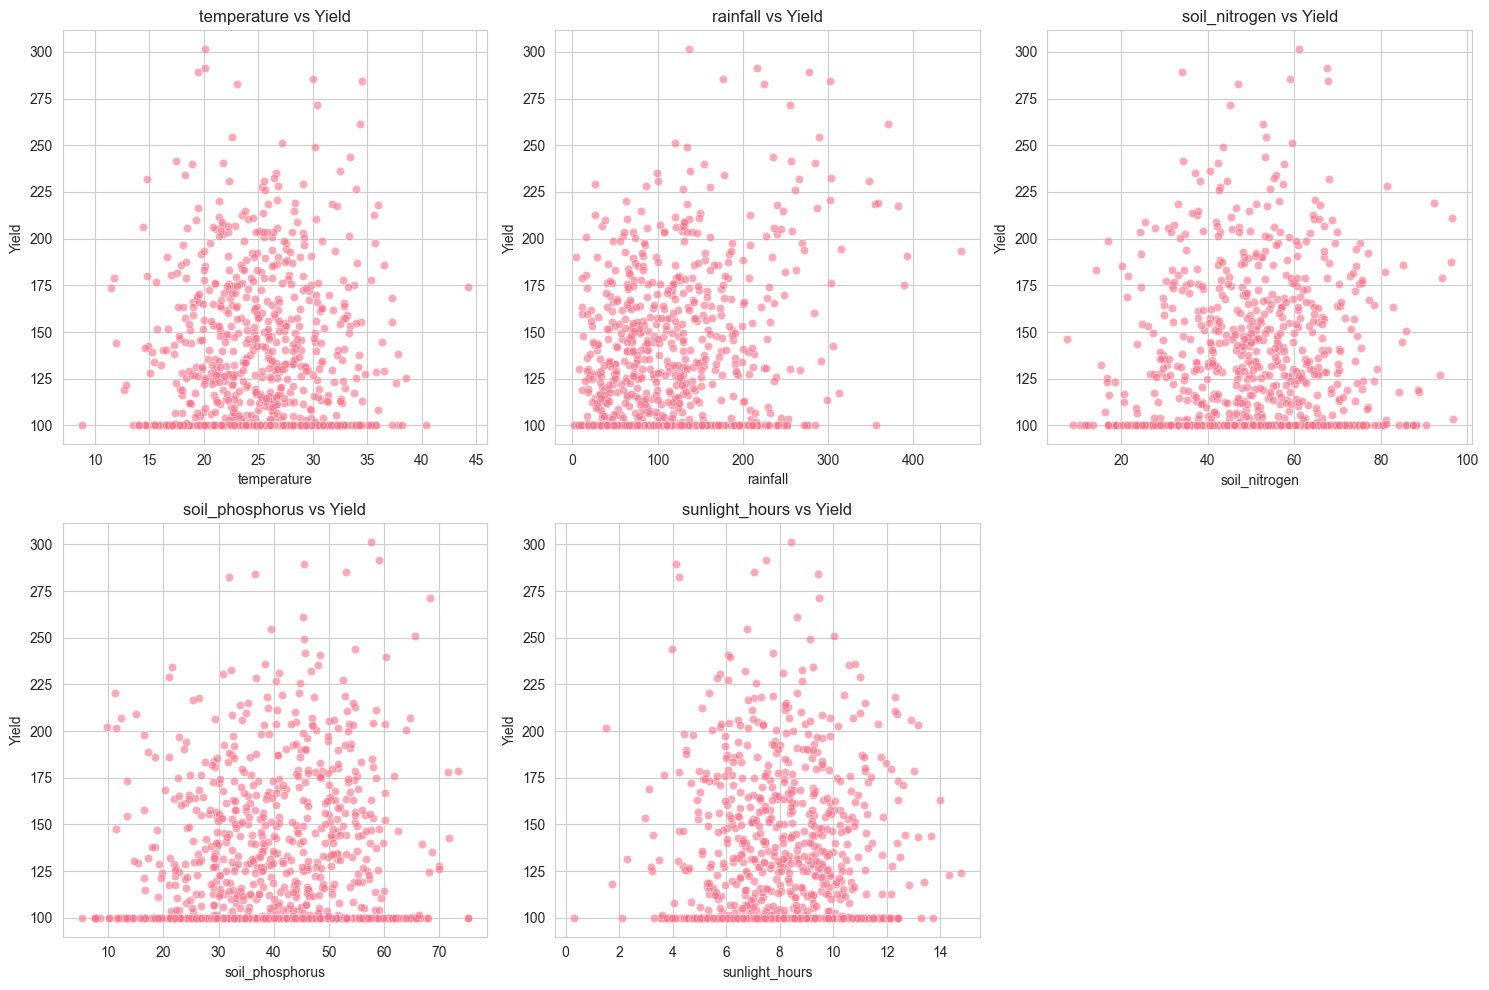

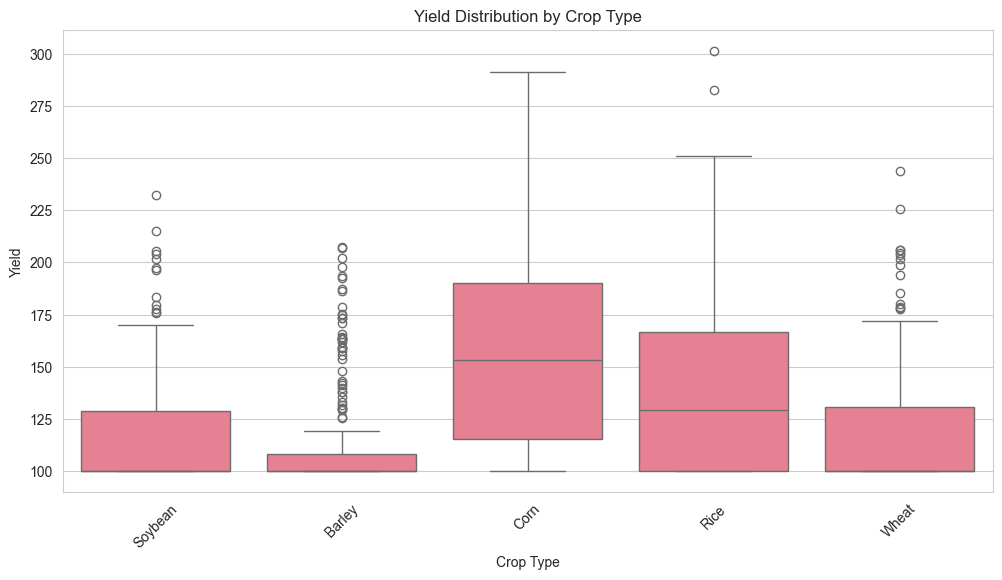

In [4]:
# %%
# Basic data exploration
print("Dataset Info:")
print(crop_data.info())
print("\nDataset Description:")
print(crop_data.describe())
print("\nMissing values:")
print(crop_data.isnull().sum())

# %%
# Visualize the distribution of numerical features
plt.figure(figsize=(15, 12))
numerical_features = ['temperature', 'rainfall', 'humidity', 'soil_ph', 
                     'soil_nitrogen', 'soil_phosphorus', 'soil_potassium', 
                     'sunlight_hours', 'yield']

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(crop_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# %%
# Crop type distribution
plt.figure(figsize=(10, 6))
crop_counts = crop_data['crop_type'].value_counts()
plt.pie(crop_counts.values, labels=crop_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Crop Types')
plt.show()

# %%
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = crop_data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# %%
# Feature relationships with yield
plt.figure(figsize=(15, 10))
features_to_plot = ['temperature', 'rainfall', 'soil_nitrogen', 'soil_phosphorus', 'sunlight_hours']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=crop_data, x=feature, y='yield', alpha=0.6)
    plt.title(f'{feature} vs Yield')
    plt.xlabel(feature)
    plt.ylabel('Yield')

plt.tight_layout()
plt.show()

# %%
# Yield by crop type
plt.figure(figsize=(12, 6))
sns.boxplot(data=crop_data, x='crop_type', y='yield')
plt.title('Yield Distribution by Crop Type')
plt.xlabel('Crop Type')
plt.ylabel('Yield')
plt.xticks(rotation=45)
plt.show()

4. Data Preprocessing

In [5]:
# %%
# Data Preprocessing
print("Starting data preprocessing...")

# Encode categorical variables
label_encoder = LabelEncoder()
crop_data['crop_type_encoded'] = label_encoder.fit_transform(crop_data['crop_type'])

# Prepare features and target
X = crop_data.drop(['yield', 'crop_type'], axis=1)
y = crop_data['yield']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("Data preprocessing completed!")

Starting data preprocessing...
Training set size: 800
Test set size: 200
Data preprocessing completed!


5. Model Training

In [6]:
# %%
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Machine': SVR(kernel='rbf')
}

# Dictionary to store results
results = {}

print("Training models...")

# %%
# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for linear models and SVM, original for tree-based models
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Support Vector Machine']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Make predictions
    y_pred = model.predict(X_te)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")

Training models...
Training Linear Regression...
Linear Regression - RMSE: 33.91, R²: 0.1473
Training Ridge Regression...
Ridge Regression - RMSE: 33.91, R²: 0.1473
Training Lasso Regression...
Lasso Regression - RMSE: 33.74, R²: 0.1562
Training Random Forest...
Random Forest - RMSE: 32.40, R²: 0.2214
Training Gradient Boosting...
Gradient Boosting - RMSE: 31.94, R²: 0.2435
Training Decision Tree...
Decision Tree - RMSE: 47.24, R²: -0.6545
Training Support Vector Machine...
Support Vector Machine - RMSE: 41.00, R²: -0.2462


6. Model Evaluation

Model Performance Comparison:
                    Model       RMSE        MAE        R²
4       Gradient Boosting  31.941280  23.624590  0.243522
3           Random Forest  32.404012  24.794038  0.221445
2        Lasso Regression  33.735431  26.432971  0.156152
1        Ridge Regression  33.912299  26.396938  0.147280
0       Linear Regression  33.912777  26.395338  0.147256
6  Support Vector Machine  40.996704  25.964935 -0.246206
5           Decision Tree  47.237491  34.305057 -0.654495


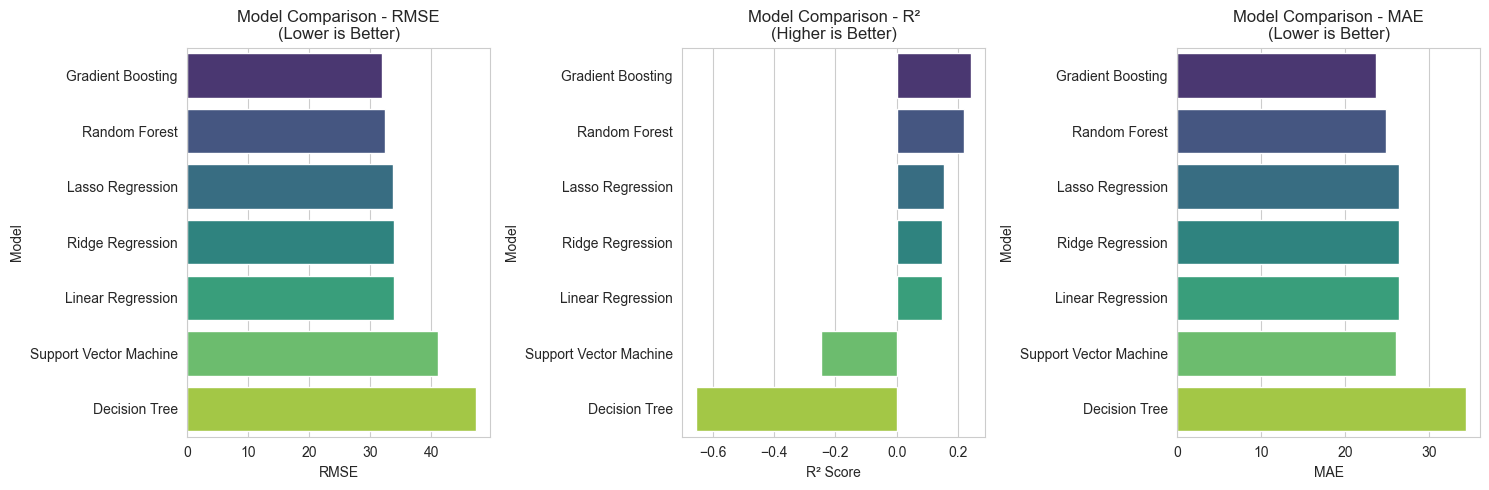

In [7]:
# %%
# Compare model performance
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['rmse'] for model in results],
    'MAE': [results[model]['mae'] for model in results],
    'R²': [results[model]['r2'] for model in results]
}).sort_values('RMSE')

print("Model Performance Comparison:")
print(performance_df)

# %%
# Visualize model performance
plt.figure(figsize=(15, 5))

# RMSE comparison
plt.subplot(1, 3, 1)
sns.barplot(data=performance_df, x='RMSE', y='Model', palette='viridis')
plt.title('Model Comparison - RMSE\n(Lower is Better)')
plt.xlabel('RMSE')

# R² comparison
plt.subplot(1, 3, 2)
sns.barplot(data=performance_df, x='R²', y='Model', palette='viridis')
plt.title('Model Comparison - R²\n(Higher is Better)')
plt.xlabel('R² Score')

# MAE comparison
plt.subplot(1, 3, 3)
sns.barplot(data=performance_df, x='MAE', y='Model', palette='viridis')
plt.title('Model Comparison - MAE\n(Lower is Better)')
plt.xlabel('MAE')

plt.tight_layout()
plt.show()

7. Feature Importance and Analysis

Feature Importance Analysis using Gradient Boosting:


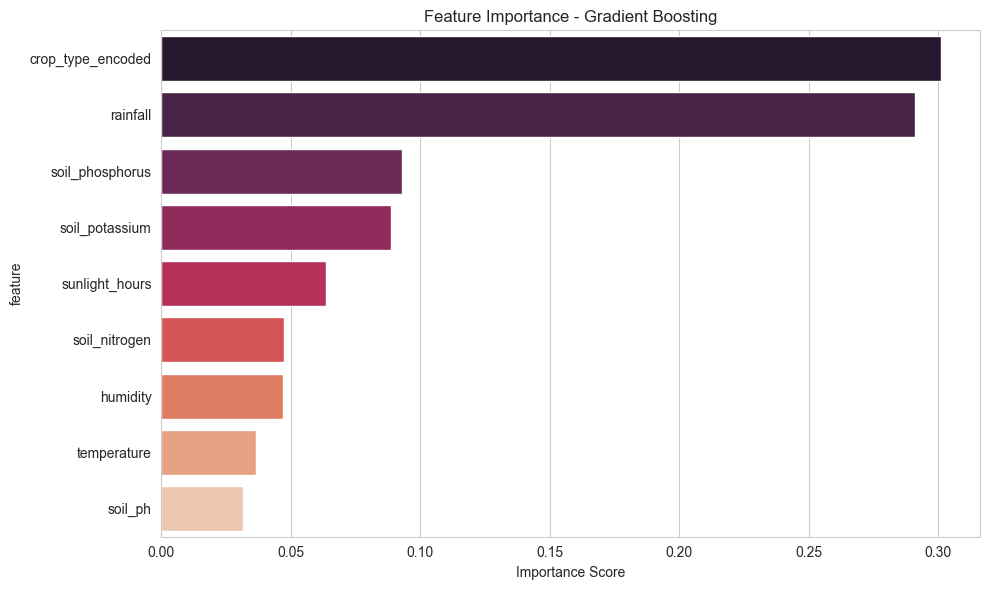

Feature Importance Scores:
             feature  importance
8  crop_type_encoded    0.301013
1           rainfall    0.291066
5    soil_phosphorus    0.092876
6     soil_potassium    0.088787
7     sunlight_hours    0.063563
4      soil_nitrogen    0.047325
2           humidity    0.047050
0        temperature    0.036602
3            soil_ph    0.031719


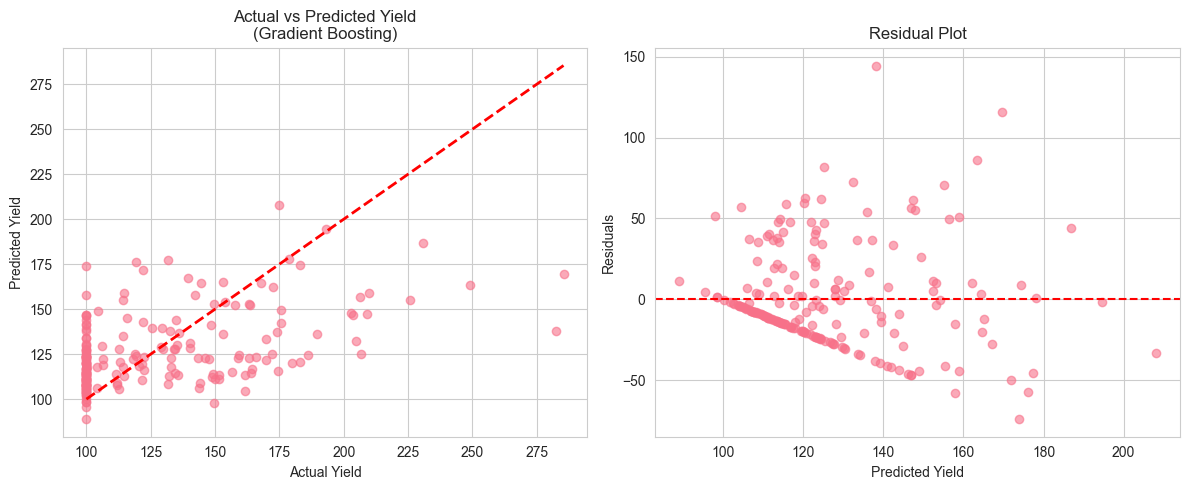

In [8]:
# %%
# Feature importance analysis using the best model (Random Forest)
best_model_name = performance_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"Feature Importance Analysis using {best_model_name}:")

if hasattr(best_model, 'feature_importances_'):
    # Tree-based model feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='rocket')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance Scores:")
    print(feature_importance)

# %%
# Actual vs Predicted values for the best model
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Actual vs Predicted Yield\n({best_model_name})')

plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

8. Advanced Analysis

In [9]:
# %%
# Model performance by crop type
crop_test = crop_data.loc[y_test.index, 'crop_type']
performance_by_crop = {}

for crop in crop_data['crop_type'].unique():
    crop_mask = crop_test == crop
    if crop_mask.sum() > 0:  # Ensure there are samples for this crop
        crop_y_true = y_test[crop_mask]
        crop_y_pred = best_predictions[crop_mask]
        
        performance_by_crop[crop] = {
            'RMSE': np.sqrt(mean_squared_error(crop_y_true, crop_y_pred)),
            'R²': r2_score(crop_y_true, crop_y_pred),
            'Samples': crop_mask.sum()
        }

# Convert to DataFrame for better visualization
crop_performance_df = pd.DataFrame(performance_by_crop).T
print("Model Performance by Crop Type:")
print(crop_performance_df)

# %%
# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    print("Performing hyperparameter tuning for Random Forest...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_tuned = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_tuned, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_rf = grid_search.best_estimator_
    y_pred_tuned = best_rf.predict(X_test)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Tuned RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_tuned)):.2f}")
    print(f"Tuned R²: {r2_score(y_test, y_pred_tuned):.4f}")

# %%
# Cross-validation scores
print("Performing cross-validation...")
cv_scores = {}

for name, model in models.items():
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Support Vector Machine']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
        
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores[name] = {
        'mean_rmse': np.sqrt(-scores.mean()),
        'std_rmse': np.sqrt(scores.std())
    }

cv_df = pd.DataFrame(cv_scores).T.sort_values('mean_rmse')
print("Cross-validation Results:")
print(cv_df)

Model Performance by Crop Type:
              RMSE        R²  Samples
Soybean  23.815266 -0.175403     40.0
Barley   23.392047  0.124074     46.0
Corn     42.572276  0.125167     34.0
Rice     40.101722  0.119183     42.0
Wheat    26.669508  0.029460     38.0
Performing cross-validation...
Cross-validation Results:
                        mean_rmse   std_rmse
Gradient Boosting       33.923956   7.238015
Random Forest           34.094755  10.665905
Lasso Regression        35.866376  10.246986
Ridge Regression        35.883854   9.991685
Linear Regression       35.884739   9.990386
Support Vector Machine  43.786587  16.041008
Decision Tree           46.224072  14.313223


9. Results and Conclusion

In [10]:
# %%
# Final model evaluation and insights
print("=" * 50)
print("FINAL PROJECT SUMMARY")
print("=" * 50)

print(f"\nBest Performing Model: {best_model_name}")
print(f"Final Test RMSE: {results[best_model_name]['rmse']:.2f}")
print(f"Final Test R² Score: {results[best_model_name]['r2']:.4f}")

print("\nKey Insights:")
print("1. Most important features for yield prediction:")
if 'feature_importance' in locals():
    top_features = feature_importance.head(3)
    for _, row in top_features.iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n2. Model performance varies by crop type:")
for crop, perf in performance_by_crop.items():
    print(f"   - {crop}: RMSE = {perf['RMSE']:.2f}, R² = {perf['R²']:.4f}")

print("\n3. Recommendations:")
print("   - Focus on soil nutrient management (Nitrogen, Phosphorus, Potassium)")
print("   - Monitor temperature and sunlight exposure")
print("   - Consider crop-specific optimization strategies")

# %%
# Save the best model and preprocessing objects
import joblib

model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_artifacts, 'crop_yield_model.pkl')
print("Model artifacts saved successfully!")

print("\nProject completed successfully!")

FINAL PROJECT SUMMARY

Best Performing Model: Gradient Boosting
Final Test RMSE: 31.94
Final Test R² Score: 0.2435

Key Insights:
1. Most important features for yield prediction:
   - crop_type_encoded: 0.3010
   - rainfall: 0.2911
   - soil_phosphorus: 0.0929

2. Model performance varies by crop type:
   - Soybean: RMSE = 23.82, R² = -0.1754
   - Barley: RMSE = 23.39, R² = 0.1241
   - Corn: RMSE = 42.57, R² = 0.1252
   - Rice: RMSE = 40.10, R² = 0.1192
   - Wheat: RMSE = 26.67, R² = 0.0295

3. Recommendations:
   - Focus on soil nutrient management (Nitrogen, Phosphorus, Potassium)
   - Monitor temperature and sunlight exposure
   - Consider crop-specific optimization strategies
Model artifacts saved successfully!

Project completed successfully!
